Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/classification-bank-marketing-all-features/auto-ml-classification-bank-marketing.png)

# Automated Machine Learning For EconML

This is a version of the evaluation for running in the cloud, it has settings that leverage greater access to compute.

## Imports

In [1]:
import logging
import sys
# Main imports
from econml.dml import DML, LinearDML,SparseLinearDML,ForestDML, NonParamDML, KernelDML
from matplotlib import pyplot as plt
import pandas as pd
import os
import copy

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.core.dataset import Dataset
from azureml.explain.model._internal.explanation_client import ExplanationClient

#Import scikit-learn model AutoML wrapper
from econml.automated_ml import addAutomatedML,setAutomatedMLWorkspace, EconAutoMLConfig
# Imports for linear double machine learning evaluation
from econml.dml import LinearDML
from matplotlib import pyplot as plt
import pandas as pd
import os
# Helper imports
import math
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV,LinearRegression,MultiTaskElasticNet,MultiTaskElasticNetCV
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


C:\Users\v-keacqu\AppData\Local\Continuum\miniconda3\envs\azure_automl\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## AutoML Setup

To begin we will configure our AutoML instance and load environment variable necessary to leverage AutoML.

In [2]:
setAutomatedMLWorkspace(workspace_name = "<workspace_name>",
                        subscription_id="<subscription_id>",
                        resource_group="<resource_group>")

Workspace configuration has succeeded.


The first step for using AutoML with double machine learning is to specify the configuration object of your AutoML target, this `AutoMLConfig` object specifies the settings of the AutoML session that will be used to develop your model.

In [3]:

automl_settings_reg = {
    "experiment_timeout_minutes" : 1,
    "enable_early_stopping" : True,
    "iteration_timeout_minutes": 1,
    "max_cores_per_iteration": -1,
    "n_cross_validations": 2,
    'preprocess': False,
    "featurization": 'off',
    "verbosity": logging.INFO,
    "primary_metric": 'normalized_mean_absolute_error'
}

automl_settings_clf = {
    "experiment_timeout_minutes" : 1,
    "enable_early_stopping" : True,
    "iteration_timeout_minutes": 1,
    "max_cores_per_iteration": -1,
    "n_cross_validations": 2,
    'preprocess': False,
    "featurization": 'off',
    "verbosity": logging.INFO,
    "primary_metric": 'AUC_weighted'
}

automl_config_reg = EconAutoMLConfig(task = 'regression',
                                     debug_log = 'automl_errors.log',
                                     enable_onnx_compatible_models=True,
                                     model_explainability=True,
                                     **automl_settings_reg)

automl_config_clf = EconAutoMLConfig(task = 'classification',
                                     debug_log = 'automl_errors.log',
                                     enable_onnx_compatible_models=True,
                                     model_explainability=True,
                                     **automl_settings_clf)



### Grid Search Baseline

In order to evaluate our model against a well performing Random Forest Classifier, we need to specify a class that completes grid search CV over the RandomForestRegressor class and chooses the best resulting model. Below is the class definition and as well as two funtions for instantiating our RandomForestRegressor wrapper.

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

class GridSearchCVList:

    def __init__(self, estimator_list, param_grid_list, scoring=None,
                 n_jobs=None, iid='warn', refit=True, cv='warn', verbose=0, pre_dispatch='2*n_jobs',
                 error_score='raise-deprecating', return_train_score=False):
        self._gcv_list = [GridSearchCV(estimator, param_grid, scoring=scoring,
                                       n_jobs=n_jobs, iid=iid, refit=refit, cv=cv, verbose=verbose,
                                       pre_dispatch=pre_dispatch, error_score=error_score,
                                       return_train_score=return_train_score)
                          for estimator, param_grid in zip(estimator_list, param_grid_list)]
        return

    def fit(self, X, y, sample_weight = None, **fit_params):
        self.best_ind_ = np.argmax([gcv.fit(X, y, sample_weight = sample_weight, **fit_params).best_score_ for gcv in self._gcv_list])
        self.best_estimator_ = self._gcv_list[self.best_ind_].best_estimator_
        self.best_score_ = self._gcv_list[self.best_ind_].best_score_
        self.best_params_ = self._gcv_list[self.best_ind_].best_params_
        return self

    def predict(self, X):
        return self.best_estimator_.predict(X)

    def predict_proba(self, X):
        return self.best_estimator_.predict_proba(X)

from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from econml.sklearn_extensions.linear_model import WeightedLassoCV

def grid_search_reg():
    return GridSearchCVList([RandomForestRegressor(n_estimators=100, random_state=123),
                             GradientBoostingRegressor(random_state=123)],
                             param_grid_list=[{'max_depth': [3, None],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=3,
                             iid=True,
                             scoring='neg_mean_squared_error')


def grid_search_clf():
    return GridSearchCVList([RandomForestClassifier(n_estimators=100, random_state=123),
                             GradientBoostingClassifier(random_state=123)],
                             param_grid_list=[{'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=3,
                             iid=True,
                             scoring='neg_mean_squared_error')

### DGP 
The DGP is described by the following equations:

\begin{align}
T =& g(W \cdot \beta) + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta + m(W\cdot \beta) + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders, $m, g$ can be nonlinear, and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta(x) = \exp(2\cdot x_1)\\
g(x) = sin^2(x)\\
m(x;\eta,\gamma)=\frac{1}{2\pi}\frac{sinh(\gamma)}{cosh(\gamma)-cos(x-\eta)}
\end{align}

Let’s keep it simple and set $\eta = 0$ and $\gamma = 1$.

### Structural Model for Estimation

The model we are trying to estimate is as follows

$$t_i = g(w_i\cdot b) + \eta$$
$$y_i = t_i\cdot \theta + m(w_i\cdot b) + \epsilon$$

For this example the true value of the causal parameter will be $\theta = 0.5$

In [5]:
# Treatment effect function
def te(x):
    return np.sin(2*math.pi*x[0])/2+0.5
def g(x):
    return np.power(np.sin(x),2)
def m(x,nu=0.,gamma=1.):
    return 0.5/math.pi*(np.sinh(gamma))/(np.cosh(gamma)-np.cos(x-nu))
#vectorized g and m for applying to dataset
vg = np.vectorize(g)
vm = np.vectorize(m)

In [6]:
# DGP constants
np.random.seed(123)
n = 10000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(np.arange(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([te(x_i) for x_i in X])

T = vg(np.dot(W[:, support_T], coefs_T))+ eta_sample(n)
Y = TE * T + vm(np.dot(W[:, support_Y], coefs_Y))+ epsilon_sample(n)

Y_train, Y_val, T_train, T_val, X_train, X_val, W_train, W_val = train_test_split(Y, T, X, W, test_size=.2)
# Generate test data
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

# Train Estimators
We train models in three different ways, and compare their performance.


# Default Setting

In [7]:
est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestRegressor(),
                random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_rf_regressor = est.effect(X_test)

In [22]:
est = LinearDML(model_y=grid_search_reg(),
                model_t=grid_search_reg(),
                random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_cv_regressor = est.effect(X_test)

In [ ]:
AutomatedLinearDML = addAutomatedML(LinearDML)
est = AutomatedLinearDML(model_y=automl_config_reg,
                         model_t=automl_config_reg,
                         random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_aml_regressor = est.effect(X_test)

Experiment model_t_20_01_31-16_34_42 has started.
Experiment model_t_20_01_31-16_34_42 completed.
Experiment model_y_20_01_31-16_36_44 has started.


## Performance Visualization

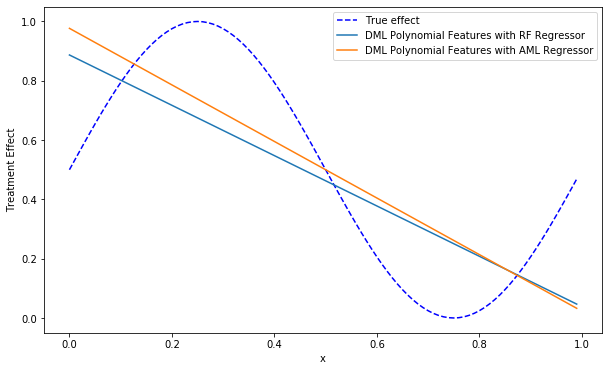

In [47]:
plt.figure(figsize=(10,6))
expected_te = np.array([te(x_i) for x_i in X_test])
plt.plot(X_test, expected_te, 'b--', label='True effect')
plt.plot(X_test, te_pred_rf_regressor, label='DML Polynomial Features with RF Regressor')
plt.plot(X_test, te_pred_aml_regressor, label='DML Polynomial Features with AML Regressor')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

# Polynomial Features with Regularization

In [48]:
est = DML(model_y=RandomForestRegressor(),
          model_t=RandomForestRegressor(),
          model_final=Lasso(alpha=0.0001, fit_intercept=False),
          featurizer=PolynomialFeatures(degree=5),
          random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_rf_regressor_2=est.effect(X_test)

In [20]:
est = DML(model_y=grid_search_reg(),
          model_t=grid_search_reg(),
          model_final=Lasso(alpha=0.0001, fit_intercept=False),
          featurizer=PolynomialFeatures(degree=5),
          random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_cv_regressor_2 = est.effect(X_test)

In [14]:
AutomatedDML = addAutomatedML(DML)
est = AutomatedDML(model_y=automl_config_reg,
                   model_t=automl_config_reg,
                   model_final=Lasso(alpha=0.0001, fit_intercept=False),
                   featurizer=PolynomialFeatures(degree=5),
                   random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_aml_regressor_2=est.effect(X_test)

Experiment model_t_20_01_28-13_56_29 has started.
Experiment model_t_20_01_28-13_56_29 completed.
Experiment model_y_20_01_28-13_58_02 has started.
Experiment model_y_20_01_28-13_58_02 completed.
Experiment model_t_20_01_28-13_59_42 has started.
Experiment model_t_20_01_28-13_59_42 completed.
Experiment model_y_20_01_28-14_01_18 has started.
Experiment model_y_20_01_28-14_01_18 completed.


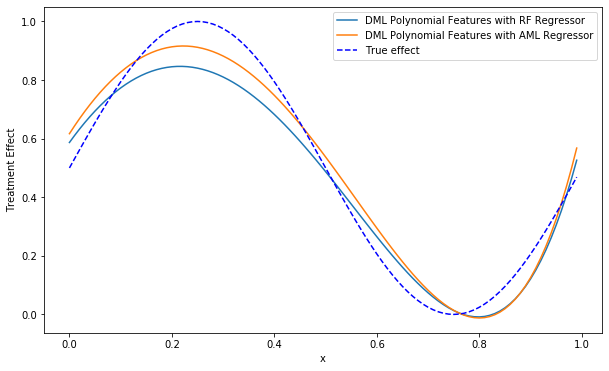

In [49]:
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred_rf_regressor_2, label='DML Polynomial Features with RF Regressor')
#plt.plot(X_test, te_pred_cv_regressor_2, label='DML Polynomial Features with Grid Search Regressor')
plt.plot(X_test, te_pred_aml_regressor_2, label='DML Polynomial Features with AML Regressor')
expected_te = np.array([te(x_i) for x_i in X_test])
plt.plot(X_test, expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

## Random Forest Final Stage


In [16]:
est = ForestDML(model_y=RandomForestRegressor(),
                model_t=RandomForestRegressor(),
                discrete_treatment=False,
                n_estimators=1000,
                subsample_fr=.8,
                min_samples_leaf=10,
                min_impurity_decrease=0.001,
                verbose=0, min_weight_fraction_leaf=.01)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_rf_regressor_3 = est.effect(X_test)

In [24]:
est = ForestDML(model_y=grid_search_reg(),
                model_t=grid_search_reg(),
                discrete_treatment=False,
                n_estimators=1000,
                subsample_fr=.8,
                min_samples_leaf=10,
                min_impurity_decrease=0.001,
                verbose=0, min_weight_fraction_leaf=.01)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pcdred_cv_regressor_3 = est.effect(X_test)

In [17]:
AutomatedForestDML = addAutomatedML(ForestDML)
est = AutomatedForestDML(model_y=automl_config_reg,
                         model_t=automl_config_reg,
                         discrete_treatment=False,
                         n_estimators=1000,
                         subsample_fr=.8,
                         min_samples_leaf=10,
                         min_impurity_decrease=0.001,
                         verbose=0, min_weight_fraction_leaf=.01)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_aml_regressor_3 = est.effect(X_test)

Experiment model_t_20_01_28-14_03_08 has started.
Experiment model_t_20_01_28-14_03_08 completed.
Experiment model_y_20_01_28-14_04_43 has started.
Experiment model_y_20_01_28-14_04_43 completed.
Experiment model_t_20_01_28-14_06_20 has started.
Experiment model_t_20_01_28-14_06_20 completed.
Experiment model_y_20_01_28-14_07_56 has started.
Experiment model_y_20_01_28-14_07_56 completed.


### Performance Visualization

In [ ]:
plt.figure(figsize=(10,6))
expected_te = np.array([te(x_i) for x_i in X_test])
plt.plot(X_test, expected_te, 'b--', label='True effect')
plt.plot(X_test, te_pred_rf_regressor_3, label='DML Polynomial Features with RF Regressor')
#plt.plot(X_test, te_pred_cv_regressor_3, label='DML Polynomial Features with Grid Search Regressor')
plt.plot(X_test, te_pred_aml_regressor_3, label='DML Polynomial Features with AML Regressor')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

## AutoML Final Stage Parametric Estimator

For correctness, all parametric double machine learning estimators (all estimators besides ``NonParamDMLEstimator``) must be trained on linear models. We can specify that using a the parameter ``linear_model_required``.


In [52]:
automl_settings_reg = {
    "experiment_timeout_minutes" : 10,
    "enable_early_stopping" : True,
    "iteration_timeout_minutes": 2,
    "max_cores_per_iteration": -1,
    "n_cross_validations": 2,
    'preprocess': False,
    "featurization": 'off',
    "verbosity": logging.INFO,
    "primary_metric": 'normalized_mean_absolute_error'
}
automl_config_final = EconAutoMLConfig(task = 'regression',
                                       debug_log = 'automl_errors.log',
                                       #For correctness, parametric DML must be linear models
                                       linear_model_required = True,
                                       **automl_settings_reg)

In [27]:
est = DML(model_y=RandomForestRegressor(),
          model_t=RandomForestRegressor(),
          model_final=RandomForestRegressor(),
          featurizer=PolynomialFeatures(degree=5),
          random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_rf_regressor_4 = est.effect(X_test)

In [28]:
est = DML(model_y=grid_search_reg(),
          model_t=grid_search_reg(),
          model_final=grid_search_reg(),
          featurizer=PolynomialFeatures(degree=5),
          random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_cv_regressor_4 = est.effect(X_test)

In [53]:
AutomatedDML = addAutomatedML(DML)
est = AutomatedDML(model_y=automl_config_reg,
                   model_t=automl_config_reg,
                   model_final=automl_config_final,
                   featurizer=PolynomialFeatures(degree=5),
                   random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_aml_regressor_4 = est.effect(X_test)

Experiment model_t_20_01_28-15_50_01 has started.
Experiment model_t_20_01_28-15_50_01 completed.
Experiment model_y_20_01_28-15_51_44 has started.
Experiment model_y_20_01_28-15_51_44 completed.
Experiment model_t_20_01_28-15_53_26 has started.
Experiment model_t_20_01_28-15_53_26 completed.
Experiment model_y_20_01_28-15_55_30 has started.
Experiment model_y_20_01_28-15_55_30 completed.
Experiment model_final_20_01_28-15_57_16 has started.
Experiment model_final_20_01_28-15_57_16 completed.


### Performance Visualization

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred_rf_regressor_4, label='DML Polynomial Features with RF Regressor')
plt.plot(X_test, te_pred_cv_regressor_4, label='DML Polynomial Features with Grid Search Regressor')
plt.plot(X_test, te_pred_aml_regressor_4, label='DML Polynomial Features with AML Regressor')
expected_te = np.array([te(x_i) for x_i in X_test])
plt.plot(X_test, expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

## With Nonlinear Models Allowed

In [43]:
AutomatedDML = addAutomatedML(DML)
est = AutomatedDML(model_y=automl_config_reg,
                   model_t=automl_config_reg,
                   model_final=automl_config_reg,
                   featurizer=PolynomialFeatures(degree=5),
                   random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_aml_regressor_4 = est.effect(X_test)

Experiment model_t_20_01_28-14_48_12 has started.
Experiment model_t_20_01_28-14_48_12 completed.
Experiment model_y_20_01_28-14_50_04 has started.
Experiment model_y_20_01_28-14_50_04 completed.
Experiment model_t_20_01_28-14_51_45 has started.
Experiment model_t_20_01_28-14_51_45 completed.
Experiment model_y_20_01_28-14_53_35 has started.
Experiment model_y_20_01_28-14_53_35 completed.
Experiment model_final_20_01_28-14_55_18 has started.
Experiment model_final_20_01_28-14_55_18 completed.


### Performance Visualization

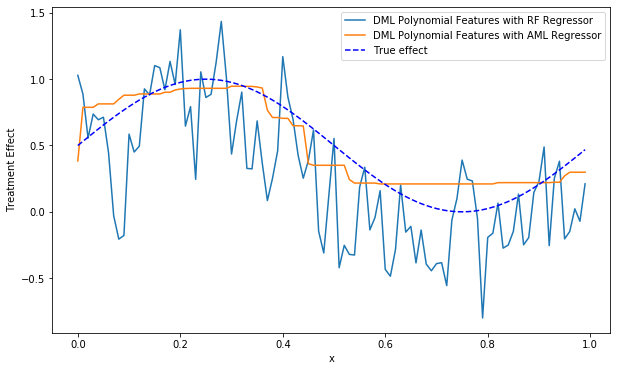

In [45]:
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred_rf_regressor_4, label='DML Polynomial Features with RF Regressor')
plt.plot(X_test, te_pred_aml_regressor_4, label='DML Polynomial Features with AML Regressor')
expected_te = np.array([te(x_i) for x_i in X_test])
plt.plot(X_test, expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

## AutoML Final Stage Nonparametric Estimator

For correctness, all nonparametric double machine learning estimators (all estimators besides ``NonParamDMLEstimator``) must be trained on models that enable sample weights. We can specify that using a the parameter ``sample_weights_required``.


In [33]:
automl_config_final = EconAutoMLConfig(task = 'regression',
                                       debug_log = 'automl_errors.log',
                                       enable_onnx_compatible_models=True,
                                       model_explainability=True,
                                       #For correctness, parametric DML must have sample weight
                                       sample_weights_required = True,
                                       **automl_settings_reg)

In [40]:
est = NonParamDML(model_y=RandomForestRegressor(),
                  model_t=RandomForestRegressor(),
                  model_final=RandomForestRegressor(),
                  random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_rf_regressor_6 = est.effect(X_test)

In [35]:
est = NonParamDML(model_y=grid_search_reg(),
                  model_t=grid_search_reg(),
                  model_final=grid_search_reg(),
                random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_cv_regressor_6 = est.effect(X_test)

In [36]:
AutomatedNonParamDML = addAutomatedML(NonParamDML)
est = AutomatedNonParamDML(model_y=automl_config_reg,
                           model_t=automl_config_reg,
                           model_final=automl_config_final,
                           random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred_aml_regressor_6 = est.effect(X_test)

Experiment model_t_20_01_28-14_36_01 has started.
Experiment model_t_20_01_28-14_36_01 completed.
Experiment model_y_20_01_28-14_37_57 has started.
Experiment model_y_20_01_28-14_37_57 completed.
Experiment model_t_20_01_28-14_39_43 has started.
Experiment model_t_20_01_28-14_39_43 completed.
Experiment model_y_20_01_28-14_41_26 has started.
Experiment model_y_20_01_28-14_41_26 completed.
Experiment model_final_20_01_28-14_43_03 has started.
Experiment model_final_20_01_28-14_43_03 completed.


### Performance Visualization

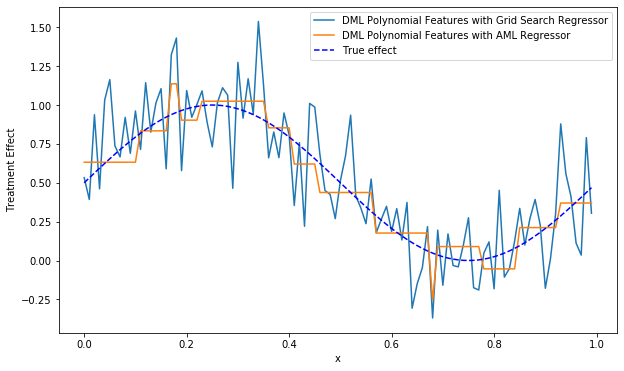

In [42]:
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred_cv_regressor_6, label='DML Polynomial Features with Grid Search Regressor')
plt.plot(X_test, te_pred_aml_regressor_6, label='DML Polynomial Features with AML Regressor')
expected_te = np.array([te(x_i) for x_i in X_test])
plt.plot(X_test, expected_te, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.ylim(-0.5, 1.5) 
plt.legend()
plt.show()

## Automated ML for Metalearners

### DGP

We use the Response Surface B from [Hill (2011)](https://www.tandfonline.com/doi/pdf/10.1198/jcgs.2010.08162) to generate sythetic outcome surfaces from real-world covariates and treatment assignments (Infant Health Development Program data). Since the original data was part of a randomized trial, a subset of the treated infants (those with non-white mothers) has been removed from the data in order to mimic the observational data setting. For more details, see [Hill (2011)](https://www.tandfonline.com/doi/pdf/10.1198/jcgs.2010.08162).


The DGP is described by the following equations:

$
Y(0) = e^{(X+W)\beta} + \epsilon_0, \;\epsilon_0 \sim N(0, 1)\\
Y(1) = X\beta - \omega + \epsilon_1, \;\epsilon_1 \sim N(0, 1)\\
$

where $X$ is a covariate matrix, $W$ is a constant matrix with entries equal to $0.5$ and $w$ is a constant calculated such that the CATT equals $4$.

In [60]:
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner
from econml.data.dgps import ihdp_surface_B
Y, T, X, expected_te = ihdp_surface_B()

In [29]:
# Instantiate T learner
T_learner_rf = TLearner(grid_search_reg())
# Train T_learner
T_learner_rf.fit(Y, T, X=X)
# Estimate treatment effects on test data
T_te_rf = T_learner_rf.effect(X)

In [31]:
# Instantiate T learner
AutomatedTLearner =  addAutomatedML(TLearner)
T_learner_aml = AutomatedTLearner(models = automl_config_reg)
# Train T_learner
T_learner_aml.fit(Y, T, X=X)
# Estimate treatment effects on test data
T_te_aml = T_learner_aml.effect(X)

Experiment models_20_01_27-12_04_27 has started.
Experiment models_20_01_27-12_04_27 completed.
Experiment models_20_01_27-12_06_04 has started.
Experiment models_20_01_27-12_06_04 completed.


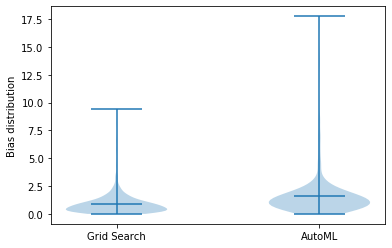

In [32]:
# Visualization of bias distribution
plt.violinplot([np.abs(T_te_rf - expected_te),
                np.abs(T_te_aml - expected_te)
               ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2], ['Grid Search', 'AutoML'])
plt.show()

# S Learner

In [36]:
# Instantiate S learner
overall_model = grid_search_reg()
S_learner_rf = SLearner(overall_model)
# Train S_learner
S_learner_rf.fit(Y, T, X=X)
# Estimate treatment effects on test data
S_te_rf = S_learner_rf.effect(X)

In [38]:
# Instantiate S learner
AutomatedSLearner =  addAutomatedML(SLearner)
S_learner_aml = AutomatedSLearner(overall_model= automl_config_reg)
# Train S_learner
S_learner_aml.fit(Y, T, X=X)
# Estimate treatment effects on test data
S_te_aml = S_learner_aml.effect(X)

Experiment overall_model_20_01_27-12_16_18 has started.
Experiment overall_model_20_01_27-12_16_18 completed.


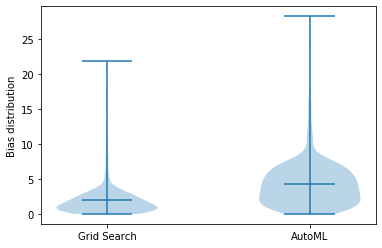

In [39]:
# Visualization of bias distribution
plt.violinplot([np.abs(S_te_rf - expected_te),
                np.abs(S_te_aml - expected_te)
               ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2], ['Grid Search', 'AutoML'])
plt.show()

# Domain Adaptation Learner

In [52]:
models = grid_search_reg()
final_models = grid_search_reg()
DA_learner_rf = DomainAdaptationLearner(models=models, final_models=final_models)
# Train DA_learner
DA_learner_rf.fit(Y, T, X=X)
# Estimate treatment effects on test data
DA_rf_te = DA_learner_rf.effect(X)

In [57]:
models = automl_config_reg
final_models = automl_config_reg
AutomatedDomainAdaptationLearner =  addAutomatedML(DomainAdaptationLearner)
DA_learner_aml = AutomatedDomainAdaptationLearner(models=models, final_models=final_models)
# Train X_learner
DA_learner_aml.fit(Y, T, X=X)
# Estimate treatment effects on test data
DA_te_aml = DA_learner_aml.effect(X)

Experiment models_20_01_27-13_19_40 has started.
Experiment models_20_01_27-13_19_40 completed.
Experiment models_20_01_27-13_21_20 has started.
Experiment models_20_01_27-13_21_20 completed.
Experiment final_models_20_01_27-13_23_01 has started.
Experiment final_models_20_01_27-13_23_01 completed.


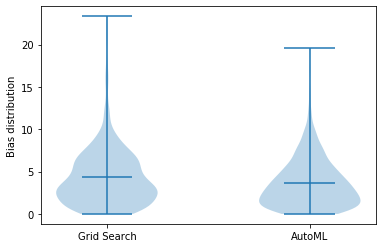

In [61]:
# Visualization of bias distribution
plt.violinplot([np.abs(DA_rf_te - expected_te),
                np.abs(DA_te_aml - expected_te)
               ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2], ['Grid Search', 'AutoML'])
plt.show()

In [71]:
Y, T, X, _ = ihdp_surface_B()
est = AutomatedNonParamDML(model_y=automl_config_reg,
                           model_t=automl_config_clf,
                           model_final=automl_config_reg, featurizer=None,
                           discrete_treatment=True)
est.fit(Y, T, X=X)
_ = est.effect(X)

Experiment model_t_20_01_27-17_24_47 has started.
Experiment model_t_20_01_27-17_24_47 completed.
Experiment model_y_20_01_27-17_27_27 has started.
Experiment model_y_20_01_27-17_27_27 completed.
Experiment model_t_20_01_27-17_29_51 has started.
Experiment model_t_20_01_27-17_29_51 completed.
Experiment model_y_20_01_27-17_32_20 has started.


WARNING - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', OSError("(10054, 'WSAECONNRESET')",))': /azureml/ExperimentRun/dcid.AutoML_ddd4742b-4d4c-46bc-b036-e42e9a60b9a1_2/outputs/scoring_file_v_1_0_0.py?sv=2019-02-02&sr=b&sig=Z%2FSYw75Z5M38OuM6L4l3run1WpF%2BB6tr5%2FIdiJkJumM%3D&st=2020-01-27T22%3A24%3A24Z&se=2020-01-28T22%3A34%3A24Z&sp=rcw&comp=block&blockid=TURBd01EQXdNREF3TURBd01EQXdNREF3TURBd01EQXdNREF3TURBd01EQSUzRA%3D%3D&timeout=30


Experiment model_y_20_01_27-17_32_20 completed.
Experiment model_final_20_01_27-17_34_55 has started.
Experiment model_final_20_01_27-17_34_55 completed.
